augmentation phase

In [1]:
%pip install torch torchvision torchaudio

  Using cached torch-2.7.1-cp312-cp312-win_amd64.whl.metadata (28 kB)
  Using cached torchvision-0.22.1-cp312-cp312-win_amd64.whl.metadata (6.1 kB)
  Using cached torchaudio-2.7.1-cp312-cp312-win_amd64.whl.metadata (6.6 kB)
  Using cached filelock-3.18.0-py3-none-any.whl.metadata (2.9 kB)
  Using cached typing_extensions-4.14.1-py3-none-any.whl.metadata (3.0 kB)
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached networkx-3.5-py3-none-any.whl.metadata (6.3 kB)
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached fsspec-2025.7.0-py3-none-any.whl.metadata (12 kB)
  Using cached setuptools-80.9.0-py3-none-any.whl.metadata (6.6 kB)
  Using cached pillow-11.3.0-cp312-cp312-win_amd64.whl.metadata (9.2 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
  Using cached MarkupSafe-3.0.2-cp312-cp312-win_amd64.whl.metadata (4.1 kB)
Using cached torch-2.7.1-cp312-cp312-win_amd64.whl (216.1 MB)
Using cached torchvision-0.22.1-cp312-cp

In [3]:
%pip install matplotlib tqdm datasets

  Using cached matplotlib-3.10.3-cp312-cp312-win_amd64.whl.metadata (11 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached datasets-4.0.0-py3-none-any.whl.metadata (19 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.59.0-cp312-cp312-win_amd64.whl.metadata (110 kB)
  Using cached kiwisolver-1.4.8-cp312-cp312-win_amd64.whl.metadata (6.3 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
  Using cached dill-0.3.8-py3-none-any.whl.metadata (10 kB)
  Using cached pandas-2.3.1-cp312-cp312-win_amd64.whl.metadata (19 kB)
  Using cached requests-2.32.4-py3-none-any.whl.metadata (4.9 kB)
  Using cached xxhash-3.5.0-cp312-cp312-win_amd64.whl.metadata (13 kB)
  Using cached multiprocess-0.70.16-py312-none-any.whl.metadata (7.2 kB)
  Using cached fsspec-2025.3.0-py3-none-any.whl.metadata (11 kB)
  Using cached PyYAML-6.0.2-cp312-cp312-win_amd64.whl.metadata (2.1 kB)
  Using cached aiohappyeyeballs-2.6.1-p

In [ ]:
# 1. SETUP AND IMPORTS
# ==============================================================================
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from datasets import load_dataset
from tqdm import tqdm

# Suppress verbose dataset loading logs
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'


d:\programming\python files(not package)\ocrtake2\file1\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# 2. DEVICE CONFIGURATION
# ==============================================================================
print("--- Device Check ---")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print("--------------------")

--- Device Check ---
Using device: cpu
--------------------


In [6]:
# 3. DATASET LOADING AND PREPARATION
# ==============================================================================
print("\n--- Loading IAM Dataset ---")
try:
    iam_dataset = load_dataset("Teklia/IAM-line")
    print("Dataset loaded successfully.")
    print(iam_dataset)
except Exception as e:
    print(f"Failed to load dataset. Please check your internet connection. Error: {e}")
    exit()

# Split the dataset
train_hf_dataset = iam_dataset["train"]
val_hf_dataset = iam_dataset["validation"]
test_hf_dataset = iam_dataset["test"]
print("--------------------------")



--- Loading IAM Dataset ---
Dataset loaded successfully.
DatasetDict({
    train: Dataset({
        features: ['image', 'text'],
        num_rows: 6482
    })
    validation: Dataset({
        features: ['image', 'text'],
        num_rows: 976
    })
    test: Dataset({
        features: ['image', 'text'],
        num_rows: 2915
    })
})
--------------------------


In [7]:
# 4. PREPROCESSING
# ==============================================================================
print("\n--- Preprocessing Data ---")

# --- Text Preprocessing ---
characters = set()
for item in train_hf_dataset:
    characters.update(list(item['text']))
characters = sorted(list(characters))
VOCAB = "".join(characters)

char_to_int = {char: i + 1 for i, char in enumerate(VOCAB)} # 0 is reserved for blank
int_to_char = {i + 1: char for i, char in enumerate(VOCAB)}
CTC_BLANK = 0

print(f"Vocabulary Size: {len(VOCAB)}")
print(f"Characters: {VOCAB}")

# --- Image Preprocessing --- 
IMG_HEIGHT = 64
IMG_WIDTH = 512

# NEW: Define separate transforms for training (with augmentation) and validation (without).
train_transform = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    # Add data augmentation
    transforms.RandomAffine(degrees=2, translate=(0.02, 0.02), scale=(0.98, 1.02), shear=2),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# --- Custom PyTorch Dataset ---
class IAMDataset(Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.hf_dataset = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.hf_dataset)

    def __getitem__(self, idx):
        item = self.hf_dataset[idx]
        try:
            image = item['image'].convert("RGB")
            text = item['text']
            if self.transform:
                image = self.transform(image)
            label = [char_to_int[char] for char in text]
            return image, torch.tensor(label, dtype=torch.long)
        except Exception as e:
            print(f"Warning: Error processing item at index {idx}. Error: {e}. Skipping.")
            return None

# --- Collate Function for DataLoader ---
def collate_fn(batch):
    batch = [b for b in batch if b is not None]
    if not batch:
        return torch.tensor([]), torch.tensor([]), torch.tensor([])
    
    images, labels = zip(*batch)
    images = torch.stack(images, 0)
    label_lengths = torch.tensor([len(label) for label in labels], dtype=torch.long)
    padded_labels = nn.utils.rnn.pad_sequence(labels, batch_first=True, padding_value=0)
    return images, padded_labels, label_lengths




--- Preprocessing Data ---
Vocabulary Size: 79
Characters:  !"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz


In [8]:
# 5. MODEL BUILDING (CRNN)
# ==============================================================================
class CRNN(nn.Module):
    def __init__(self, num_chars):
        super(CRNN, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.map_to_seq = nn.Linear(64 * (IMG_HEIGHT // 4), 64)
        self.rnn = nn.LSTM(64, 128, num_layers=2, bidirectional=True, dropout=0.25)
        self.fc = nn.Linear(256, num_chars)

    def forward(self, x):
        x = self.cnn(x)
        x = x.permute(0, 3, 1, 2)
        b, w, c, h = x.size()
        x = x.view(b, w, c * h)
        x = self.map_to_seq(x)
        x = x.permute(1, 0, 2)
        x, _ = self.rnn(x)
        x = self.fc(x)
        x = nn.functional.log_softmax(x, dim=2)
        return x

In [9]:
# 6. TRAINING AND VALIDATION FUNCTIONS
# ==============================================================================
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    epoch_loss = 0
    for images, labels, label_lengths in tqdm(dataloader, desc="Training"):
        if images.size(0) == 0:
            continue
        images, labels, label_lengths = images.to(device), labels.to(device), label_lengths.to(device)
        optimizer.zero_grad()
        log_probs = model(images)
        input_lengths = torch.full(size=(images.size(0),), fill_value=log_probs.size(0), dtype=torch.long)
        loss = criterion(log_probs, labels, input_lengths, label_lengths)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(dataloader)

def validate_one_epoch(model, dataloader, criterion, device):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for images, labels, label_lengths in tqdm(dataloader, desc="Validating"):
            if images.size(0) == 0:
                continue
            images, labels, label_lengths = images.to(device), labels.to(device), label_lengths.to(device)
            log_probs = model(images)
            input_lengths = torch.full(size=(images.size(0),), fill_value=log_probs.size(0), dtype=torch.long)
            loss = criterion(log_probs, labels, input_lengths, label_lengths)
            epoch_loss += loss.item()
    return epoch_loss / len(dataloader)

In [10]:
# 7. INFERENCE FUNCTION
# ==============================================================================
def ctc_decode(log_probs):
    preds = log_probs.argmax(dim=2).permute(1, 0)
    decoded_texts = []
    for pred in preds:
        s = ''.join([int_to_char.get(c.item(), '') for c in pred if c != CTC_BLANK])
        dedup_s = ""
        if s:
            dedup_s = s[0]
            for char in s[1:]:
                if char != dedup_s[-1]:
                    dedup_s += char
        decoded_texts.append(dedup_s)
    return decoded_texts



--- Initializing DataLoaders ---
Preprocessing complete. PyTorch DataLoaders created.
--------------------------------

--- Building CRNN Model ---
--- Loaded weights from 'handwriting_recognizer_best.pth' to continue training. ---
CRNN(
  (cnn): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (map_to_seq): Linear(in_features=1024, out_features=64, bias=True)
  (rnn): LSTM(64, 128, num_layers=2, dropout=0.25, bidirectional=True)
  (fc): Linear(in_features=256, out_features=80, bias=True)
)
--------------------------

--- Training Model ---


Validating: 100%|██████████| 31/31 [00:11<00:00,  2.59it/s]



Epoch 1/50 - Train Loss: 0.7758, Val Loss: 0.5098
Model saved after epoch 1 to epoch_models\handwriting_recognizer_epoch_1.pth
Model improved. Saved best model to handwriting_recognizer_best.pth


Validating: 100%|██████████| 31/31 [00:11<00:00,  2.68it/s]



Epoch 2/50 - Train Loss: 0.6117, Val Loss: 0.4915
Model saved after epoch 2 to epoch_models\handwriting_recognizer_epoch_2.pth
Model improved. Saved best model to handwriting_recognizer_best.pth


Validating: 100%|██████████| 31/31 [00:12<00:00,  2.58it/s]



Epoch 3/50 - Train Loss: 0.5722, Val Loss: 0.4794
Model saved after epoch 3 to epoch_models\handwriting_recognizer_epoch_3.pth
Model improved. Saved best model to handwriting_recognizer_best.pth


Validating: 100%|██████████| 31/31 [00:11<00:00,  2.60it/s]



Epoch 4/50 - Train Loss: 0.5540, Val Loss: 0.4672
Model saved after epoch 4 to epoch_models\handwriting_recognizer_epoch_4.pth
Model improved. Saved best model to handwriting_recognizer_best.pth


Validating: 100%|██████████| 31/31 [00:11<00:00,  2.62it/s]



Epoch 5/50 - Train Loss: 0.5309, Val Loss: 0.4744
Model saved after epoch 5 to epoch_models\handwriting_recognizer_epoch_5.pth
No improvement. Patience: 1/10


Validating: 100%|██████████| 31/31 [00:11<00:00,  2.62it/s]



Epoch 6/50 - Train Loss: 0.5146, Val Loss: 0.4626
Model saved after epoch 6 to epoch_models\handwriting_recognizer_epoch_6.pth
Model improved. Saved best model to handwriting_recognizer_best.pth


Validating: 100%|██████████| 31/31 [00:11<00:00,  2.60it/s]



Epoch 7/50 - Train Loss: 0.5037, Val Loss: 0.4509
Model saved after epoch 7 to epoch_models\handwriting_recognizer_epoch_7.pth
Model improved. Saved best model to handwriting_recognizer_best.pth


Validating: 100%|██████████| 31/31 [00:12<00:00,  2.55it/s]



Epoch 8/50 - Train Loss: 0.4881, Val Loss: 0.4454
Model saved after epoch 8 to epoch_models\handwriting_recognizer_epoch_8.pth
Model improved. Saved best model to handwriting_recognizer_best.pth


Validating: 100%|██████████| 31/31 [00:12<00:00,  2.57it/s]



Epoch 9/50 - Train Loss: 0.4821, Val Loss: 0.4477
Model saved after epoch 9 to epoch_models\handwriting_recognizer_epoch_9.pth
No improvement. Patience: 1/10


Validating: 100%|██████████| 31/31 [00:11<00:00,  2.61it/s]



Epoch 10/50 - Train Loss: 0.4741, Val Loss: 0.4414
Model saved after epoch 10 to epoch_models\handwriting_recognizer_epoch_10.pth
Model improved. Saved best model to handwriting_recognizer_best.pth


Validating: 100%|██████████| 31/31 [00:12<00:00,  2.58it/s]



Epoch 11/50 - Train Loss: 0.4629, Val Loss: 0.4457
Model saved after epoch 11 to epoch_models\handwriting_recognizer_epoch_11.pth
No improvement. Patience: 1/10


Validating: 100%|██████████| 31/31 [00:11<00:00,  2.65it/s]



Epoch 12/50 - Train Loss: 0.4654, Val Loss: 0.4550
Model saved after epoch 12 to epoch_models\handwriting_recognizer_epoch_12.pth
No improvement. Patience: 2/10


Validating: 100%|██████████| 31/31 [00:11<00:00,  2.62it/s]



Epoch 13/50 - Train Loss: 0.4451, Val Loss: 0.4399
Model saved after epoch 13 to epoch_models\handwriting_recognizer_epoch_13.pth
Model improved. Saved best model to handwriting_recognizer_best.pth


Validating: 100%|██████████| 31/31 [00:11<00:00,  2.61it/s]



Epoch 14/50 - Train Loss: 0.4420, Val Loss: 0.4512
Model saved after epoch 14 to epoch_models\handwriting_recognizer_epoch_14.pth
No improvement. Patience: 1/10


Validating: 100%|██████████| 31/31 [00:11<00:00,  2.64it/s]



Epoch 15/50 - Train Loss: 0.4269, Val Loss: 0.4311
Model saved after epoch 15 to epoch_models\handwriting_recognizer_epoch_15.pth
Model improved. Saved best model to handwriting_recognizer_best.pth


Validating: 100%|██████████| 31/31 [00:11<00:00,  2.60it/s]



Epoch 16/50 - Train Loss: 0.4227, Val Loss: 0.4228
Model saved after epoch 16 to epoch_models\handwriting_recognizer_epoch_16.pth
Model improved. Saved best model to handwriting_recognizer_best.pth


Validating: 100%|██████████| 31/31 [00:11<00:00,  2.59it/s]



Epoch 17/50 - Train Loss: 0.4125, Val Loss: 0.4210
Model saved after epoch 17 to epoch_models\handwriting_recognizer_epoch_17.pth
Model improved. Saved best model to handwriting_recognizer_best.pth


Validating: 100%|██████████| 31/31 [00:11<00:00,  2.60it/s]



Epoch 18/50 - Train Loss: 0.4081, Val Loss: 0.4096
Model saved after epoch 18 to epoch_models\handwriting_recognizer_epoch_18.pth
Model improved. Saved best model to handwriting_recognizer_best.pth


Validating: 100%|██████████| 31/31 [00:11<00:00,  2.62it/s]



Epoch 19/50 - Train Loss: 0.4015, Val Loss: 0.4211
Model saved after epoch 19 to epoch_models\handwriting_recognizer_epoch_19.pth
No improvement. Patience: 1/10


Validating: 100%|██████████| 31/31 [00:11<00:00,  2.61it/s]



Epoch 20/50 - Train Loss: 0.4013, Val Loss: 0.4129
Model saved after epoch 20 to epoch_models\handwriting_recognizer_epoch_20.pth
No improvement. Patience: 2/10


Validating: 100%|██████████| 31/31 [00:11<00:00,  2.61it/s]



Epoch 21/50 - Train Loss: 0.3937, Val Loss: 0.4145
Model saved after epoch 21 to epoch_models\handwriting_recognizer_epoch_21.pth
No improvement. Patience: 3/10


Validating: 100%|██████████| 31/31 [00:11<00:00,  2.62it/s]



Epoch 22/50 - Train Loss: 0.3901, Val Loss: 0.4074
Model saved after epoch 22 to epoch_models\handwriting_recognizer_epoch_22.pth
Model improved. Saved best model to handwriting_recognizer_best.pth


Validating: 100%|██████████| 31/31 [00:11<00:00,  2.62it/s]



Epoch 23/50 - Train Loss: 0.3779, Val Loss: 0.4056
Model saved after epoch 23 to epoch_models\handwriting_recognizer_epoch_23.pth
Model improved. Saved best model to handwriting_recognizer_best.pth


Validating: 100%|██████████| 31/31 [00:11<00:00,  2.64it/s]



Epoch 24/50 - Train Loss: 0.3755, Val Loss: 0.4097
Model saved after epoch 24 to epoch_models\handwriting_recognizer_epoch_24.pth
No improvement. Patience: 1/10


Validating: 100%|██████████| 31/31 [00:11<00:00,  2.63it/s]



Epoch 25/50 - Train Loss: 0.3688, Val Loss: 0.4105
Model saved after epoch 25 to epoch_models\handwriting_recognizer_epoch_25.pth
No improvement. Patience: 2/10


Validating: 100%|██████████| 31/31 [00:11<00:00,  2.65it/s]



Epoch 26/50 - Train Loss: 0.3641, Val Loss: 0.4055
Model saved after epoch 26 to epoch_models\handwriting_recognizer_epoch_26.pth
Model improved. Saved best model to handwriting_recognizer_best.pth


Validating: 100%|██████████| 31/31 [00:11<00:00,  2.67it/s]



Epoch 27/50 - Train Loss: 0.3613, Val Loss: 0.4056
Model saved after epoch 27 to epoch_models\handwriting_recognizer_epoch_27.pth
No improvement. Patience: 1/10


Validating: 100%|██████████| 31/31 [00:11<00:00,  2.61it/s]



Epoch 28/50 - Train Loss: 0.3591, Val Loss: 0.4064
Model saved after epoch 28 to epoch_models\handwriting_recognizer_epoch_28.pth
No improvement. Patience: 2/10


Validating: 100%|██████████| 31/31 [00:12<00:00,  2.58it/s]



Epoch 29/50 - Train Loss: 0.3476, Val Loss: 0.4044
Model saved after epoch 29 to epoch_models\handwriting_recognizer_epoch_29.pth
Model improved. Saved best model to handwriting_recognizer_best.pth


Validating: 100%|██████████| 31/31 [00:11<00:00,  2.65it/s]



Epoch 30/50 - Train Loss: 0.3464, Val Loss: 0.3999
Model saved after epoch 30 to epoch_models\handwriting_recognizer_epoch_30.pth
Model improved. Saved best model to handwriting_recognizer_best.pth


Validating: 100%|██████████| 31/31 [00:11<00:00,  2.59it/s]



Epoch 31/50 - Train Loss: 0.3487, Val Loss: 0.3957
Model saved after epoch 31 to epoch_models\handwriting_recognizer_epoch_31.pth
Model improved. Saved best model to handwriting_recognizer_best.pth


Validating: 100%|██████████| 31/31 [00:11<00:00,  2.61it/s]



Epoch 32/50 - Train Loss: 0.3388, Val Loss: 0.4009
Model saved after epoch 32 to epoch_models\handwriting_recognizer_epoch_32.pth
No improvement. Patience: 1/10


Validating: 100%|██████████| 31/31 [00:11<00:00,  2.63it/s]



Epoch 33/50 - Train Loss: 0.3331, Val Loss: 0.3980
Model saved after epoch 33 to epoch_models\handwriting_recognizer_epoch_33.pth
No improvement. Patience: 2/10


Validating: 100%|██████████| 31/31 [00:11<00:00,  2.63it/s]



Epoch 34/50 - Train Loss: 0.3352, Val Loss: 0.4044
Model saved after epoch 34 to epoch_models\handwriting_recognizer_epoch_34.pth
No improvement. Patience: 3/10


Validating: 100%|██████████| 31/31 [00:11<00:00,  2.63it/s]



Epoch 35/50 - Train Loss: 0.3276, Val Loss: 0.3881
Model saved after epoch 35 to epoch_models\handwriting_recognizer_epoch_35.pth
Model improved. Saved best model to handwriting_recognizer_best.pth


Validating: 100%|██████████| 31/31 [00:11<00:00,  2.68it/s]



Epoch 36/50 - Train Loss: 0.3283, Val Loss: 0.3975
Model saved after epoch 36 to epoch_models\handwriting_recognizer_epoch_36.pth
No improvement. Patience: 1/10


Validating: 100%|██████████| 31/31 [00:11<00:00,  2.65it/s]



Epoch 37/50 - Train Loss: 0.3217, Val Loss: 0.3844
Model saved after epoch 37 to epoch_models\handwriting_recognizer_epoch_37.pth
Model improved. Saved best model to handwriting_recognizer_best.pth


Validating: 100%|██████████| 31/31 [00:11<00:00,  2.70it/s]



Epoch 38/50 - Train Loss: 0.3103, Val Loss: 0.3903
Model saved after epoch 38 to epoch_models\handwriting_recognizer_epoch_38.pth
No improvement. Patience: 1/10


Validating: 100%|██████████| 31/31 [00:11<00:00,  2.66it/s]



Epoch 39/50 - Train Loss: 0.3095, Val Loss: 0.3979
Model saved after epoch 39 to epoch_models\handwriting_recognizer_epoch_39.pth
No improvement. Patience: 2/10


Validating: 100%|██████████| 31/31 [00:11<00:00,  2.66it/s]



Epoch 40/50 - Train Loss: 0.3175, Val Loss: 0.3907
Model saved after epoch 40 to epoch_models\handwriting_recognizer_epoch_40.pth
No improvement. Patience: 3/10


Validating: 100%|██████████| 31/31 [00:11<00:00,  2.70it/s]



Epoch 41/50 - Train Loss: 0.3024, Val Loss: 0.3706
Model saved after epoch 41 to epoch_models\handwriting_recognizer_epoch_41.pth
Model improved. Saved best model to handwriting_recognizer_best.pth


Validating: 100%|██████████| 31/31 [00:11<00:00,  2.67it/s]



Epoch 42/50 - Train Loss: 0.3027, Val Loss: 0.3920
Model saved after epoch 42 to epoch_models\handwriting_recognizer_epoch_42.pth
No improvement. Patience: 1/10


Validating: 100%|██████████| 31/31 [00:11<00:00,  2.67it/s]



Epoch 43/50 - Train Loss: 0.3018, Val Loss: 0.3894
Model saved after epoch 43 to epoch_models\handwriting_recognizer_epoch_43.pth
No improvement. Patience: 2/10


Validating: 100%|██████████| 31/31 [00:11<00:00,  2.70it/s]



Epoch 44/50 - Train Loss: 0.2965, Val Loss: 0.3769
Model saved after epoch 44 to epoch_models\handwriting_recognizer_epoch_44.pth
No improvement. Patience: 3/10


Validating: 100%|██████████| 31/31 [00:11<00:00,  2.71it/s]



Epoch 45/50 - Train Loss: 0.3007, Val Loss: 0.3912
Model saved after epoch 45 to epoch_models\handwriting_recognizer_epoch_45.pth
No improvement. Patience: 4/10


Validating: 100%|██████████| 31/31 [00:11<00:00,  2.68it/s]



Epoch 46/50 - Train Loss: 0.2678, Val Loss: 0.3734
Model saved after epoch 46 to epoch_models\handwriting_recognizer_epoch_46.pth
No improvement. Patience: 5/10


Validating: 100%|██████████| 31/31 [00:11<00:00,  2.69it/s]



Epoch 47/50 - Train Loss: 0.2588, Val Loss: 0.3674
Model saved after epoch 47 to epoch_models\handwriting_recognizer_epoch_47.pth
Model improved. Saved best model to handwriting_recognizer_best.pth


Validating: 100%|██████████| 31/31 [00:11<00:00,  2.69it/s]



Epoch 48/50 - Train Loss: 0.2558, Val Loss: 0.3659
Model saved after epoch 48 to epoch_models\handwriting_recognizer_epoch_48.pth
Model improved. Saved best model to handwriting_recognizer_best.pth


Validating: 100%|██████████| 31/31 [00:11<00:00,  2.67it/s]



Epoch 49/50 - Train Loss: 0.2515, Val Loss: 0.3636
Model saved after epoch 49 to epoch_models\handwriting_recognizer_epoch_49.pth
Model improved. Saved best model to handwriting_recognizer_best.pth


Validating: 100%|██████████| 31/31 [00:11<00:00,  2.69it/s]



Epoch 50/50 - Train Loss: 0.2484, Val Loss: 0.3685
Model saved after epoch 50 to epoch_models\handwriting_recognizer_epoch_50.pth
No improvement. Patience: 1/10
Training finished.
---------------------

--- Evaluating Model and Running Inference ---


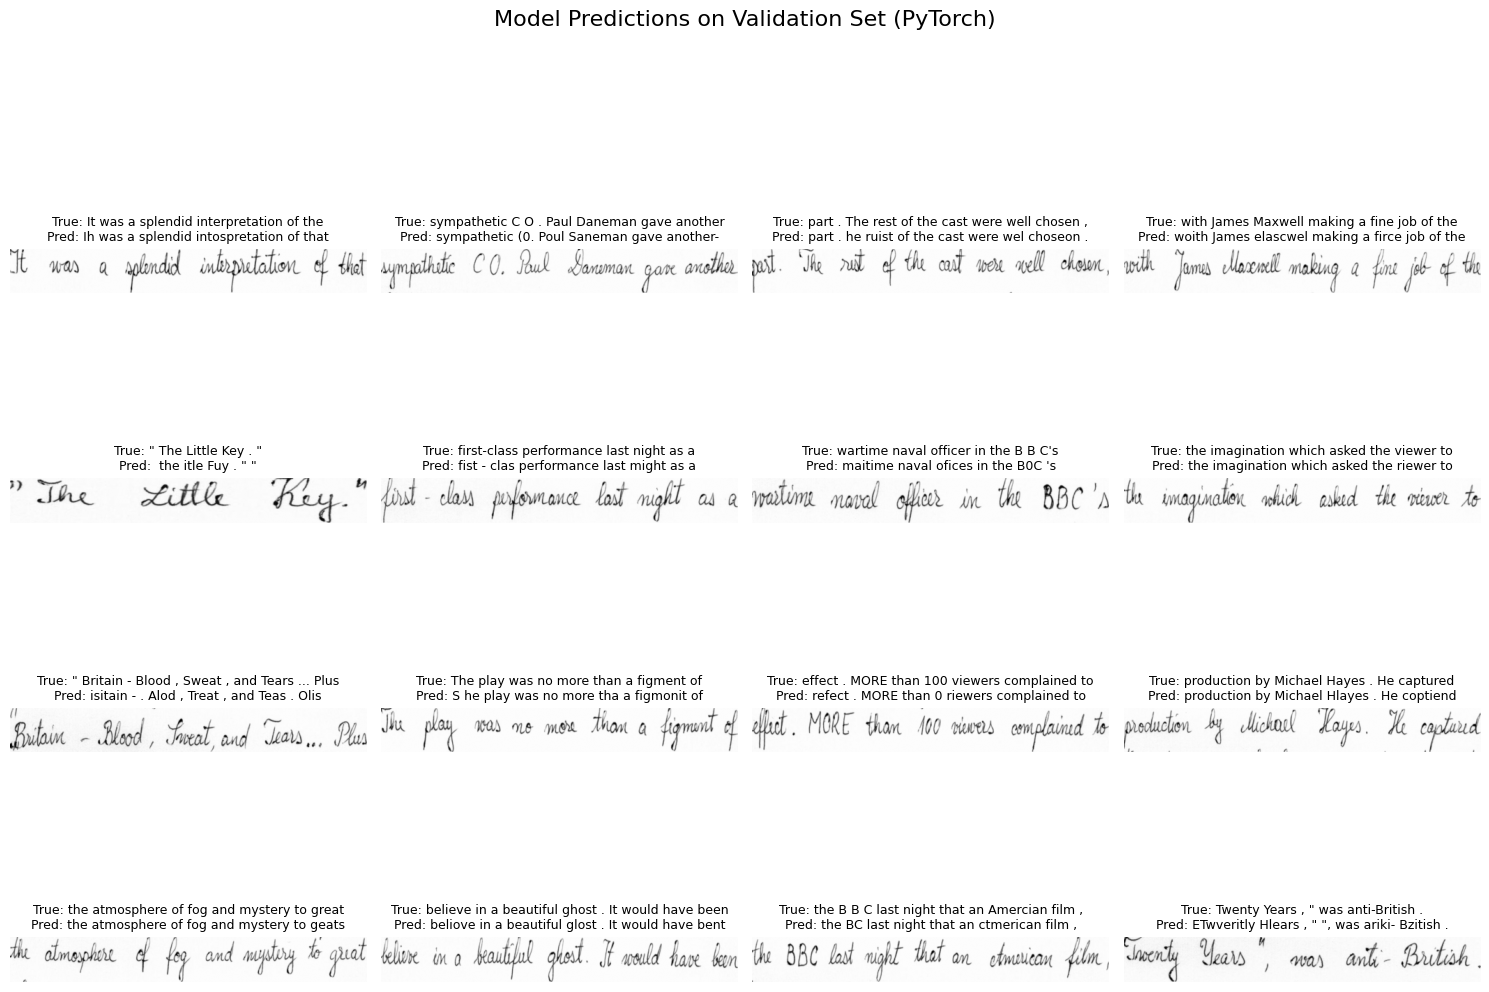

---------------------------------------------

--- Saving Final Model Locally ---
Final model state dict saved as 'handwriting_recognizer_final.pth'
Best performing model state dict saved as 'handwriting_recognizer_best.pth'
All epoch-wise models are saved in the 'epoch_models/' directory.
----------------------------------


In [12]:
# ==============================================================================
# MAIN EXECUTION BLOCK
# ==============================================================================
if __name__ == '__main__':
    print("\n--- Initializing DataLoaders ---")
    BATCH_SIZE = 32
    
    # NEW: Use the appropriate transform for each dataset split
    train_dataset = IAMDataset(train_hf_dataset, transform=train_transform)
    val_dataset = IAMDataset(val_hf_dataset, transform=val_transform)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn, num_workers=0)
    
    print("Preprocessing complete. PyTorch DataLoaders created.")
    print("--------------------------------")

    print("\n--- Building CRNN Model ---")
    model = CRNN(num_chars=len(VOCAB) + 1).to(device)
    
    # NEW: Load model weights if a checkpoint exists to resume training
    if os.path.exists('handwriting_recognizer_best.pth'):
        model.load_state_dict(torch.load('handwriting_recognizer_best.pth', map_location=device))
        print("--- Loaded weights from 'handwriting_recognizer_best.pth' to continue training. ---")
    
    print(model)
    print("--------------------------")

    print("\n--- Training Model ---")
    criterion = nn.CTCLoss(blank=CTC_BLANK, zero_infinity=True)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # NEW: Add a learning rate scheduler
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=3)

    epochs = 50
    best_val_loss = float('inf')
    patience = 10
    patience_counter = 0

    epoch_models_dir = 'epoch_models'
    if not os.path.exists(epoch_models_dir):
        os.makedirs(epoch_models_dir)

    for epoch in range(epochs):
        train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
        val_loss = validate_one_epoch(model, val_loader, criterion, device)
        
        # NEW: Step the scheduler with the validation loss
        scheduler.step(val_loss)
        
        print(f"\nEpoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        
        epoch_save_path = os.path.join(epoch_models_dir, f'handwriting_recognizer_epoch_{epoch+1}.pth')
        torch.save(model.state_dict(), epoch_save_path)
        print(f"Model saved after epoch {epoch+1} to {epoch_save_path}")
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'handwriting_recognizer_best.pth')
            print(f"Model improved. Saved best model to handwriting_recognizer_best.pth")
            patience_counter = 0
        else:
            patience_counter += 1
            print(f"No improvement. Patience: {patience_counter}/{patience}")

        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

    print("Training finished.")
    print("---------------------")

    print("\n--- Evaluating Model and Running Inference ---")
    prediction_model = CRNN(num_chars=len(VOCAB) + 1).to(device)
    prediction_model.load_state_dict(torch.load('handwriting_recognizer_best.pth', map_location=device))
    prediction_model.eval()

    data_iter = iter(val_loader)
    images, labels, _ = next(data_iter)
    images = images.to(device)

    with torch.no_grad():
        log_probs = prediction_model(images)

    pred_texts = ctc_decode(log_probs)

    orig_texts = []
    for label_tensor in labels:
        text = "".join([int_to_char.get(c.item(), '') for c in label_tensor if c != 0])
        orig_texts.append(text)

    _, axes = plt.subplots(4, 4, figsize=(15, 12))

    for i in range(min(16, BATCH_SIZE)):
        if i >= images.size(0):
            break
        img = images[i].cpu().numpy().squeeze()
        img = (img * 0.5 + 0.5) * 255
        img = np.clip(img, 0, 255).astype(np.uint8)
        
        ax = axes[i // 4, i % 4]
        ax.imshow(img, cmap="gray")
        ax.set_title(f"True: {orig_texts[i]}\nPred: {pred_texts[i]}", fontsize=9)
        ax.axis("off")

    plt.suptitle("Model Predictions on Validation Set (PyTorch)", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    print("---------------------------------------------")

    print("\n--- Saving Final Model Locally ---")
    torch.save(model.state_dict(), "handwriting_recognizer_final.pth")
    print("Final model state dict saved as 'handwriting_recognizer_final.pth'")
    print("Best performing model state dict saved as 'handwriting_recognizer_best.pth'")
    print(f"All epoch-wise models are saved in the '{epoch_models_dir}/' directory.")
    print("----------------------------------")